In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
import os 

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
from PIL import Image
from PIL import ImageEnhance
import matplotlib.cm as cm

import torchvision.datasets as dset
import torchvision.transforms as T
import chest_xray_code.data.xrays as preprocess_dataset
import chest_xray_code.data.raw_reports as utils
import os
import torch.nn.functional as F
from models.NewConvModel import NewConvNet 
from models.TestConvNet import TestConvNet
from loaders.XrayLoader import XrayLoader
from loaders.BloodCellLoader import BloodCellLoader
from loaders.MuseumLoader import MuseumLoader

import numpy as np

In [7]:
xray_set = XrayLoader(
    root='chest_xray_code/data/xrays',
    preload=False, transform=transforms.ToTensor(),
)
xray_loader = DataLoader(xray_set, batch_size=20, shuffle=True, num_workers=32)

blood_set = BloodCellLoader(
    root='blood_cells_data/dataset-master/JPEGImages',
    preload=False, transform=transforms.ToTensor(),
)

blood_cell_loader = DataLoader(blood_set, batch_size=20, shuffle=True, num_workers=32)


museum_set = MuseumLoader(
    root='museum_data/dataset_updated/training_set',
    preload=False, transform=transforms.ToTensor(),
)

museum_loader = DataLoader(museum_set, batch_size=20, shuffle=True, num_workers=32)

print(len(museum_set))
print(len(blood_set))
print(len(xray_set))

500
366
500


In [8]:
transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

images = {}

In [9]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    #dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 5


In [16]:
channels = 3
size = 32
net_type = 'old'#'new' #'old'
original_dataset = 'blood_cell' #'museum' #'xray' 
cross_dataset = 'blood_cell'
model = None
hook = None

In [17]:
if model == None: #ensure that we don't keep loading it over and over
    if net_type == 'new':
        model = NewConvNet(channels,size,device)
        if original_dataset == 'blood_cell':
            model = torch.load('trained_models/blood5.pt')
            print("loaded blood5.pt")
        elif original_dataset == 'museum':
            model = torch.load('trained_models/new_museum.pt')
            print("loaded new_museum.pt")
        else:
            model = torch.load('trained_models/new_xray.pt')
            print("loaded new_xray.pt")
    else:
        model = TestConvNet(channels,size)
        if original_dataset == 'blood_cell':
            model = torch.load('trained_models/blood_200_1000.pt')
            print("loaded blood_200_1000.pt")
        elif original_dataset == 'museum':
            model = torch.load('trained_models/old_museum.pt')
            print("loaded old_museum.pt")
        else:
            model = torch.load('trained_models/xraymodelV2.pt')
            print("loaded xraymodelV2.pt")

        model.to(device)
        
        
if cross_dataset == 'museum':
    cross_dataset_loader = museum_loader
elif cross_dataset == 'xray':
    cross_dataset_loader = xray_loader
else:
    cross_dataset_loader = blood_cell_loader


loaded blood_200_1000.pt


/home/shared/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.TestConvNet.TestConvNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


Visualize the Compressed images 

In [18]:
def prep(img):
    img = img.numpy()
    if True:
        img_max, img_min = np.max(img), np.min(img)
        img = .9* (img - img_min) / (img_max - img_min) 
    return np.transpose(img, (1, 2, 0)) 

def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):
        individual_img = img[i]
        images[1].append(prep(individual_img))

        
def save_original(data):
    img = data.cpu().detach()

    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        images[0].append(individual_img)

def visualize(net_type,original_dataset,cross_dataset,device):
    model = None
    

    if model == None: #ensure that we don't keep loading it over and over
        if net_type == 'new':
            model = NewConvNet(channels,size,device)
            if original_dataset == 'blood_cell':
                model = torch.load('trained_models/blood5.pt')
                print("loaded blood5.pt")
            elif original_dataset == 'museum':
                model = torch.load('trained_models/new_museum.pt')
                print("loaded new_museum.pt")
            else:
                model = torch.load('trained_models/new_xray.pt')
                print("loaded new_xray.pt")
        else:
            model = TestConvNet(channels,size)
            if original_dataset == 'blood_cell':
                model = torch.load('trained_models/blood_200_1000.pt')
                print("loaded blood_200_1000.pt")
            elif original_dataset == 'museum':
                model = torch.load('trained_models/old_museum.pt')
                print("loaded old_museum.pt")
            else:
                model = torch.load('trained_models/xraymodelV2.pt')
                print("loaded xraymodelV2.pt")

            model.to(device)
            
    if hook == None: 
        hook = model.conv_compress_final.register_forward_hook(save_compressed)     
        
        
    if cross_dataset == 'museum':
        cross_dataset_loader = museum_loader
    elif cross_dataset == 'xray':
        cross_dataset_loader = xray_loader
    else:
        cross_dataset_loader = blood_cell_loader
    
    
    
    
    plt.close("all")


    images = [[],[]]


    i = 0
    reconstruction = None
    for data in cross_dataset_loader:
        with torch.no_grad():
            if i > 0: break
            data = data.to(device)
            save_original(data)
            reconstruction = model(data)
            i+=1

    for i in range(10):
        plt.figure(figsize=(100,100))
        #plt.figure()
        org = images[0][i]
        plt.subplot(1, 3, 1)
        plt.axis('off')
        #imshow_noax(org, normalize=False)
        plt.imshow(org)
        plt.title('Original')
        plt.subplot(1, 3, 2)
        rec = images[1][i]
        plt.imshow(rec)
        #imshow_noax(rec, normalize=False)
        plt.title('Compressed')
        plt.axis('off')
        image_str = net_type + "_" + original_dataset + "_" +cross_dataset+"_"+str(i) + ".png"
        plt.subplot(1, 3, 3)
        plt.axis('off')
        recon = reconstruction[i].cpu().detach()
        recon = recon.numpy()
        recon = np.transpose(recon,(1,2,0))
        recon = np.clip(recon,0,1)
        plt.imshow(recon)
        plt.title('Reconstructed')
        plt.savefig("cross_visualizations/"+image_str)
        plt.show()



Store Images as JPEG with same compression rate that we are achieving 

1329 1
1329 2
1336 3
1368 4
1391 5
1414 6
1442 7
1459 8
1484 9
1514 10
1533 11
1553 12
1589 13
1602 14
1636 15
1654 16
1676 17
1702 18
1722 19
1739 20
1766 21
1790 22
1818 23
1841 24
1855 25
1880 26
1911 27
1932 28
1955 29
1984 30
2013 31
2025 32
2059 33
2069 34
2097 35
2120 36
2145 37
2185 38
2202 39
2207 40
2246 41
2271 42
2281 43
2317 44
2335 45
2370 46
2372 47
2417 48
2462 49
2462 50
2464 51
2501 52
2549 53
2554 54
2572 55
2603 56
2654 57
2697 58
2719 59
2735 60
2787 61
2805 62
2876 63
2901 64
2953 65
2989 66
3036 67
3106 68
3158 69
3209 70
3274 71
3300 72
3409 73
3515 74
3525 75
3591 76
3728 77
3860 78
3904 79
4015 80
4164 81
4269 82
4481 83
4609 84
4757 85
5003 86
5169 87
5435 88
5665 89
6076 90
6396 91
6639 92
7331 93
8089 94
8929 95
10091 96
11462 97
13233 98
16796 99
1327 1
1327 2
1327 3
1336 4
1361 5
1370 6
1379 7
1410 8
1430 9
1450 10
1466 11
1478 12
1500 13
1517 14
1527 15
1552 16
1569 17
1584 18
1588 19
1598 20
1621 21
1634 22
1648 23
1664 24
1683 25
1700 26
1724 27
1740 2

3237 74
3243 75
3309 76
3426 77
3559 78
3602 79
3713 80
3858 81
3949 82
4145 83
4297 84
4422 85
4643 86
4806 87
5071 88
5262 89
5643 90
5964 91
6203 92
6833 93
7539 94
8318 95
9409 96
10710 97
12366 98
15710 99
1324 1
1324 2
1328 3
1351 4
1384 5
1401 6
1406 7
1426 8
1453 9
1469 10
1490 11
1500 12
1520 13
1546 14
1569 15
1590 16
1609 17
1630 18
1646 19
1658 20
1673 21
1698 22
1719 23
1737 24
1754 25
1772 26
1786 27
1812 28
1824 29
1839 30
1861 31
1881 32
1906 33
1915 34
1942 35
1958 36
1971 37
2009 38
2028 39
2032 40
2066 41
2093 42
2106 43
2137 44
2155 45
2171 46
2173 47
2216 48
2249 49
2249 50
2249 51
2288 52
2338 53
2345 54
2361 55
2384 56
2427 57
2467 58
2481 59
2493 60
2545 61
2560 62
2613 63
2626 64
2682 65
2716 66
2750 67
2819 68
2864 69
2904 70
2966 71
2979 72
3069 73
3167 74
3174 75
3228 76
3352 77
3465 78
3498 79
3594 80
3748 81
3842 82
4017 83
4148 84
4282 85
4508 86
4652 87
4922 88
5105 89
5471 90
5776 91
6007 92
6586 93
7304 94
8092 95
9139 96
10464 97
12011 98
15283 99
133

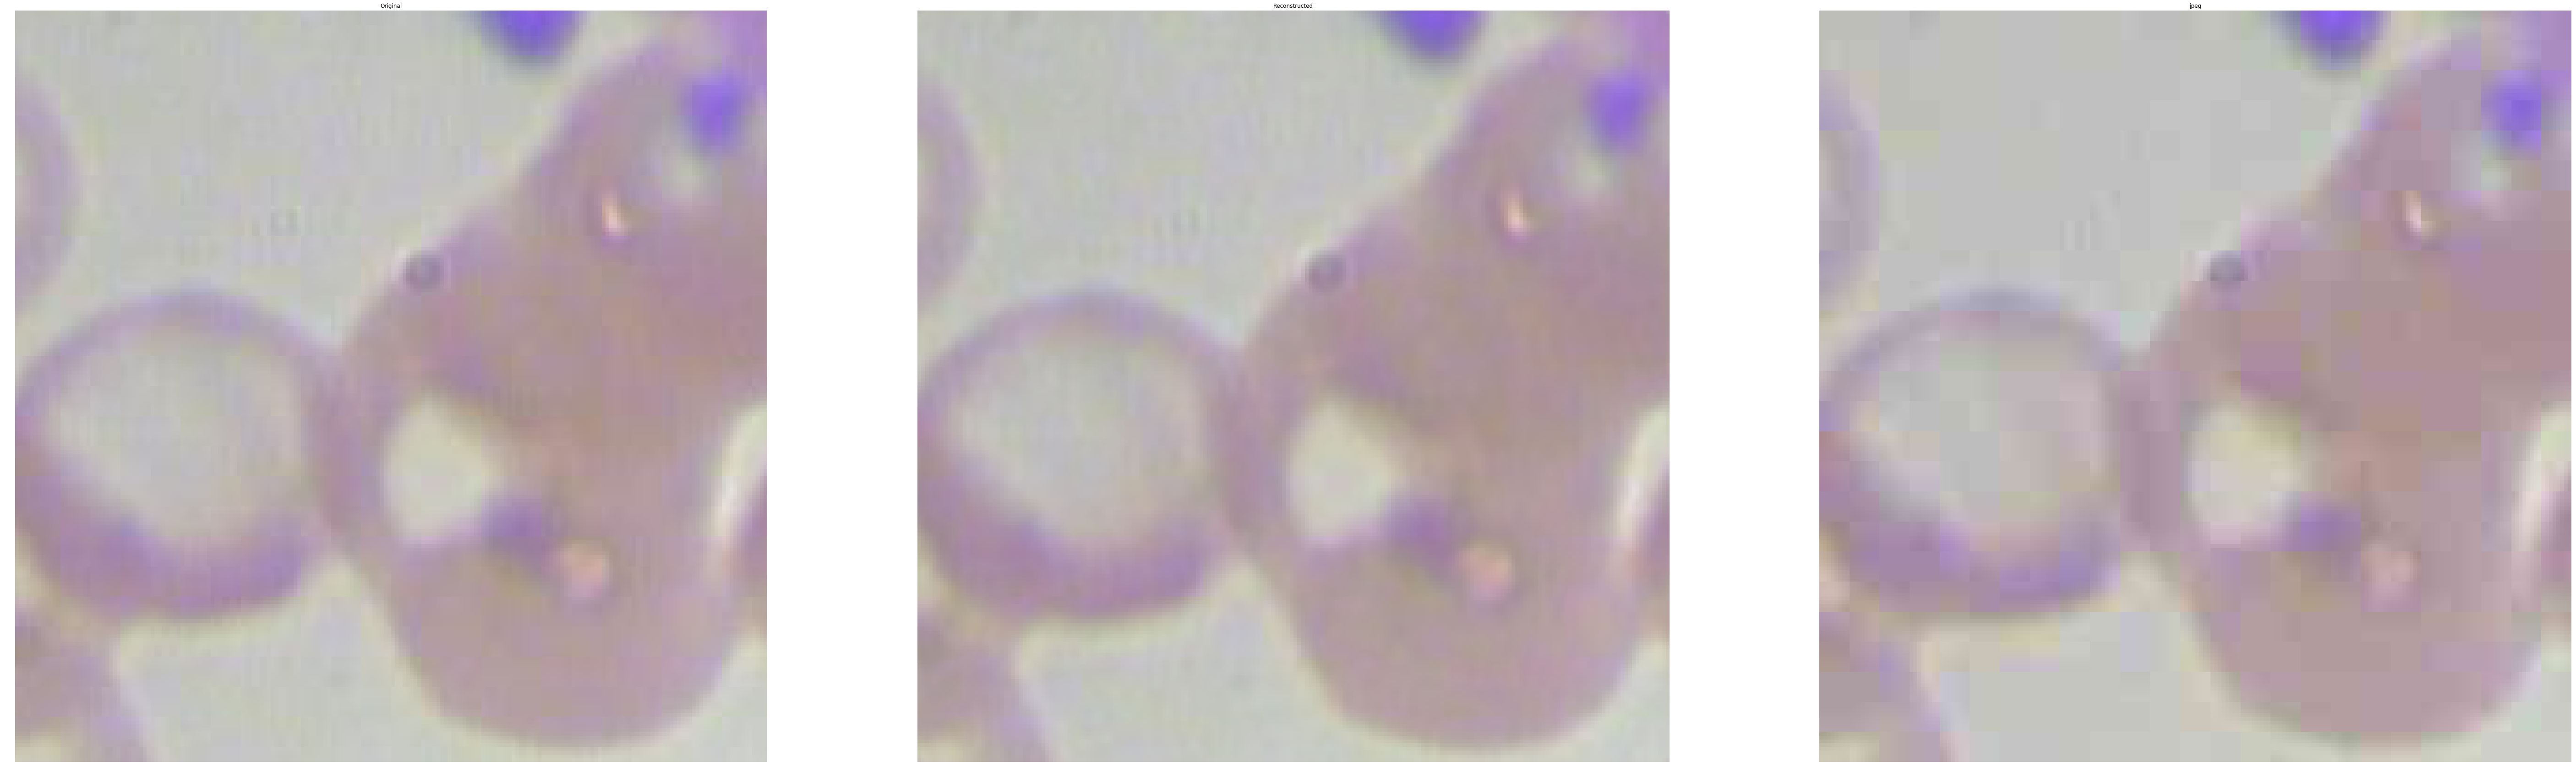

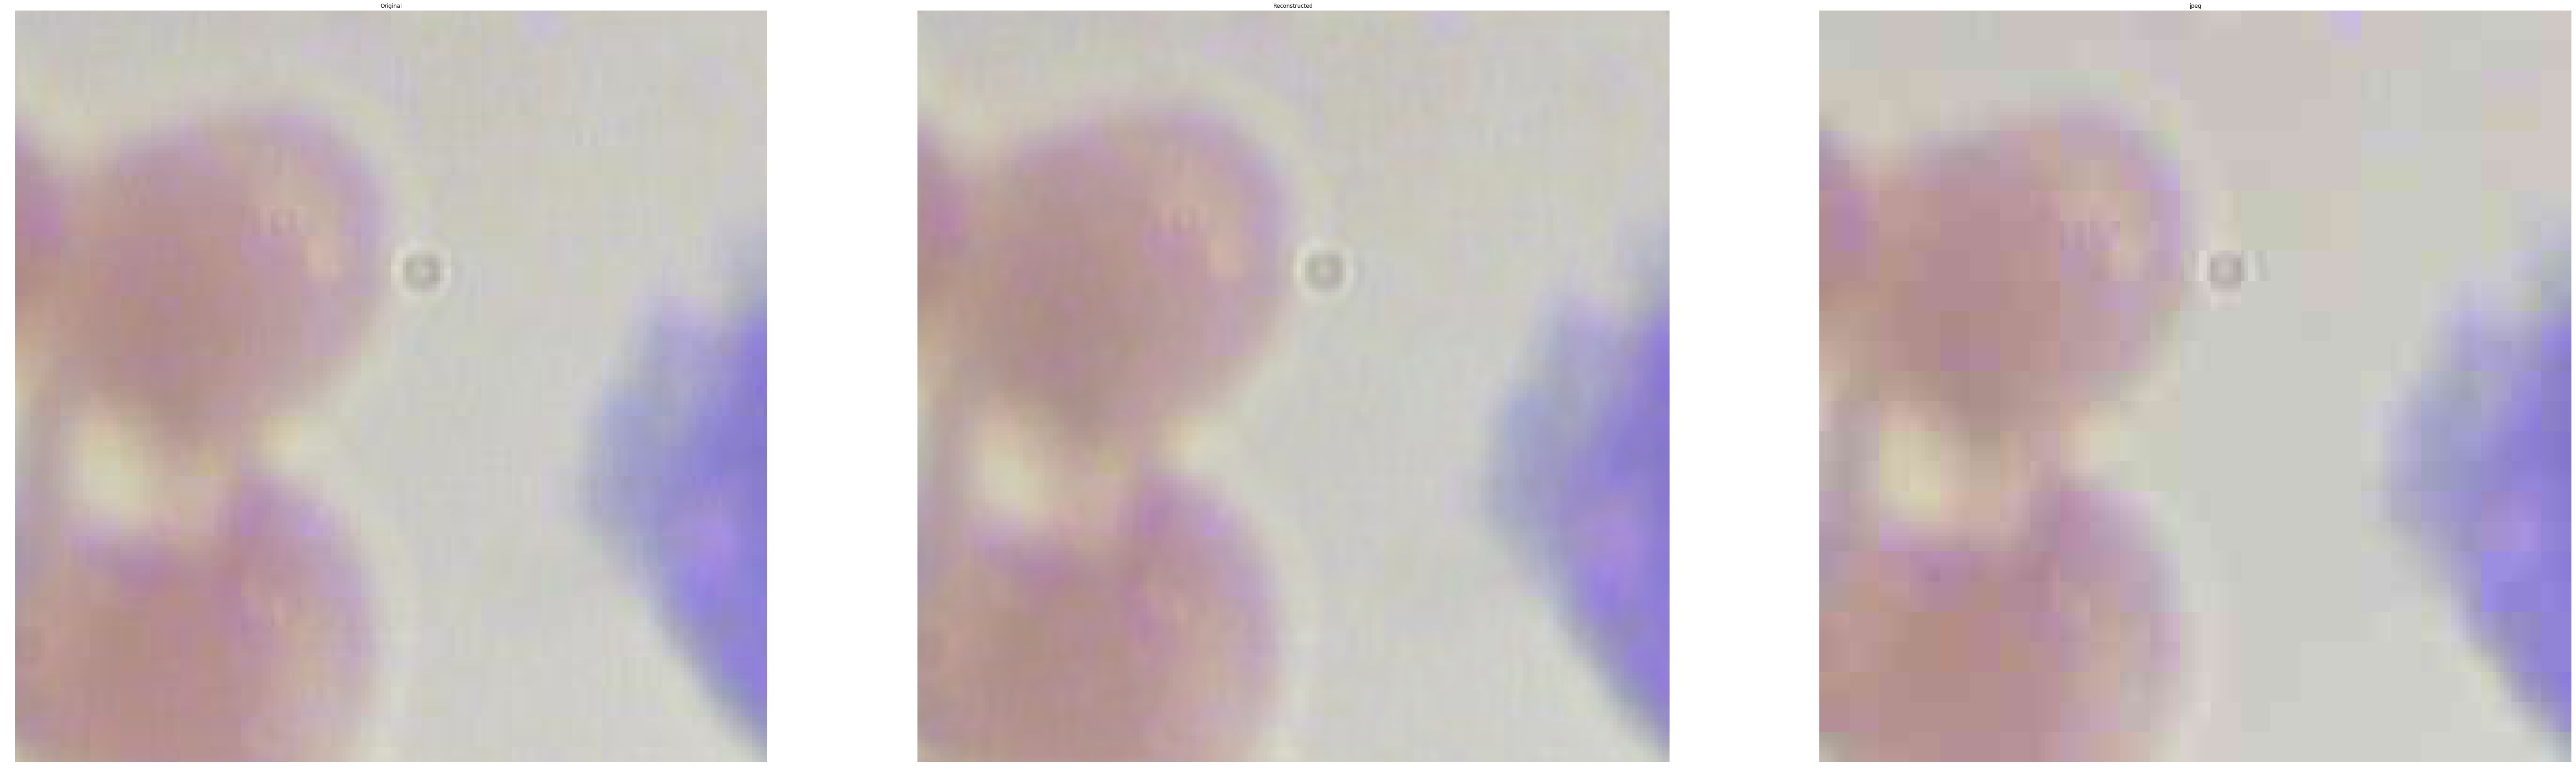

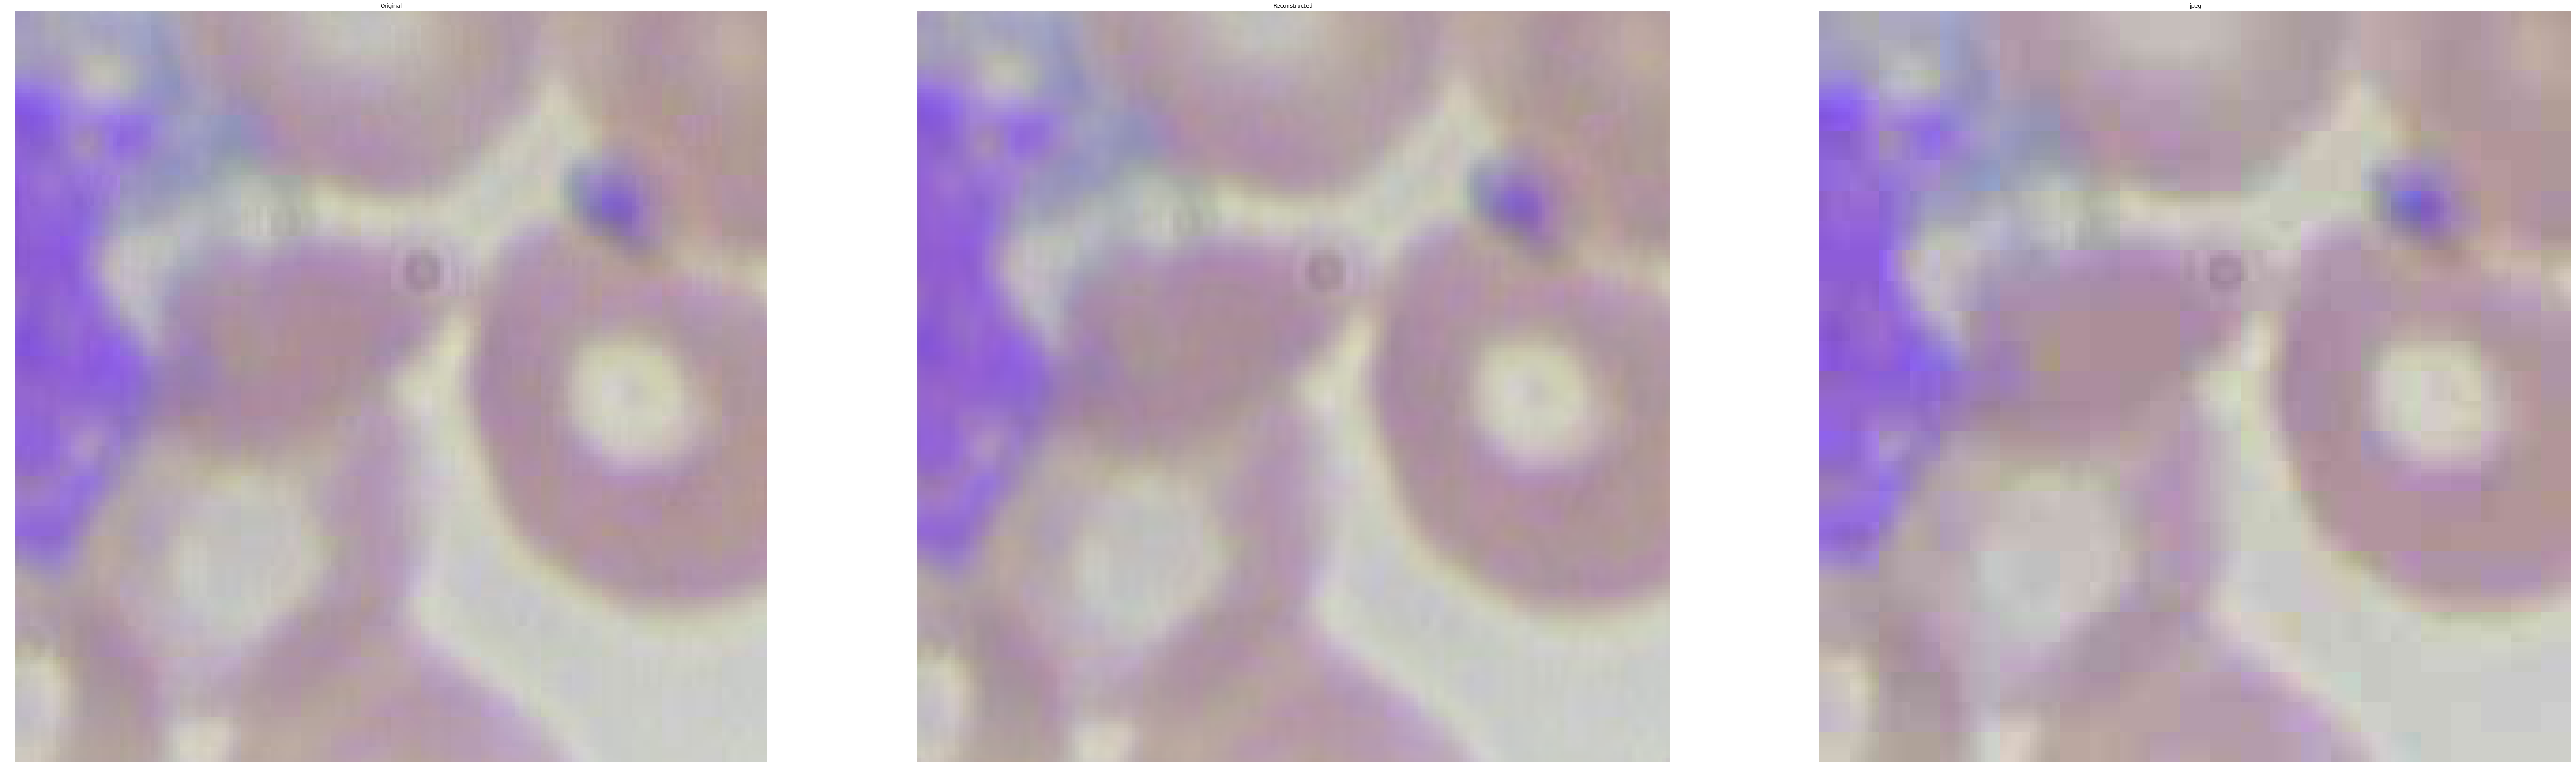

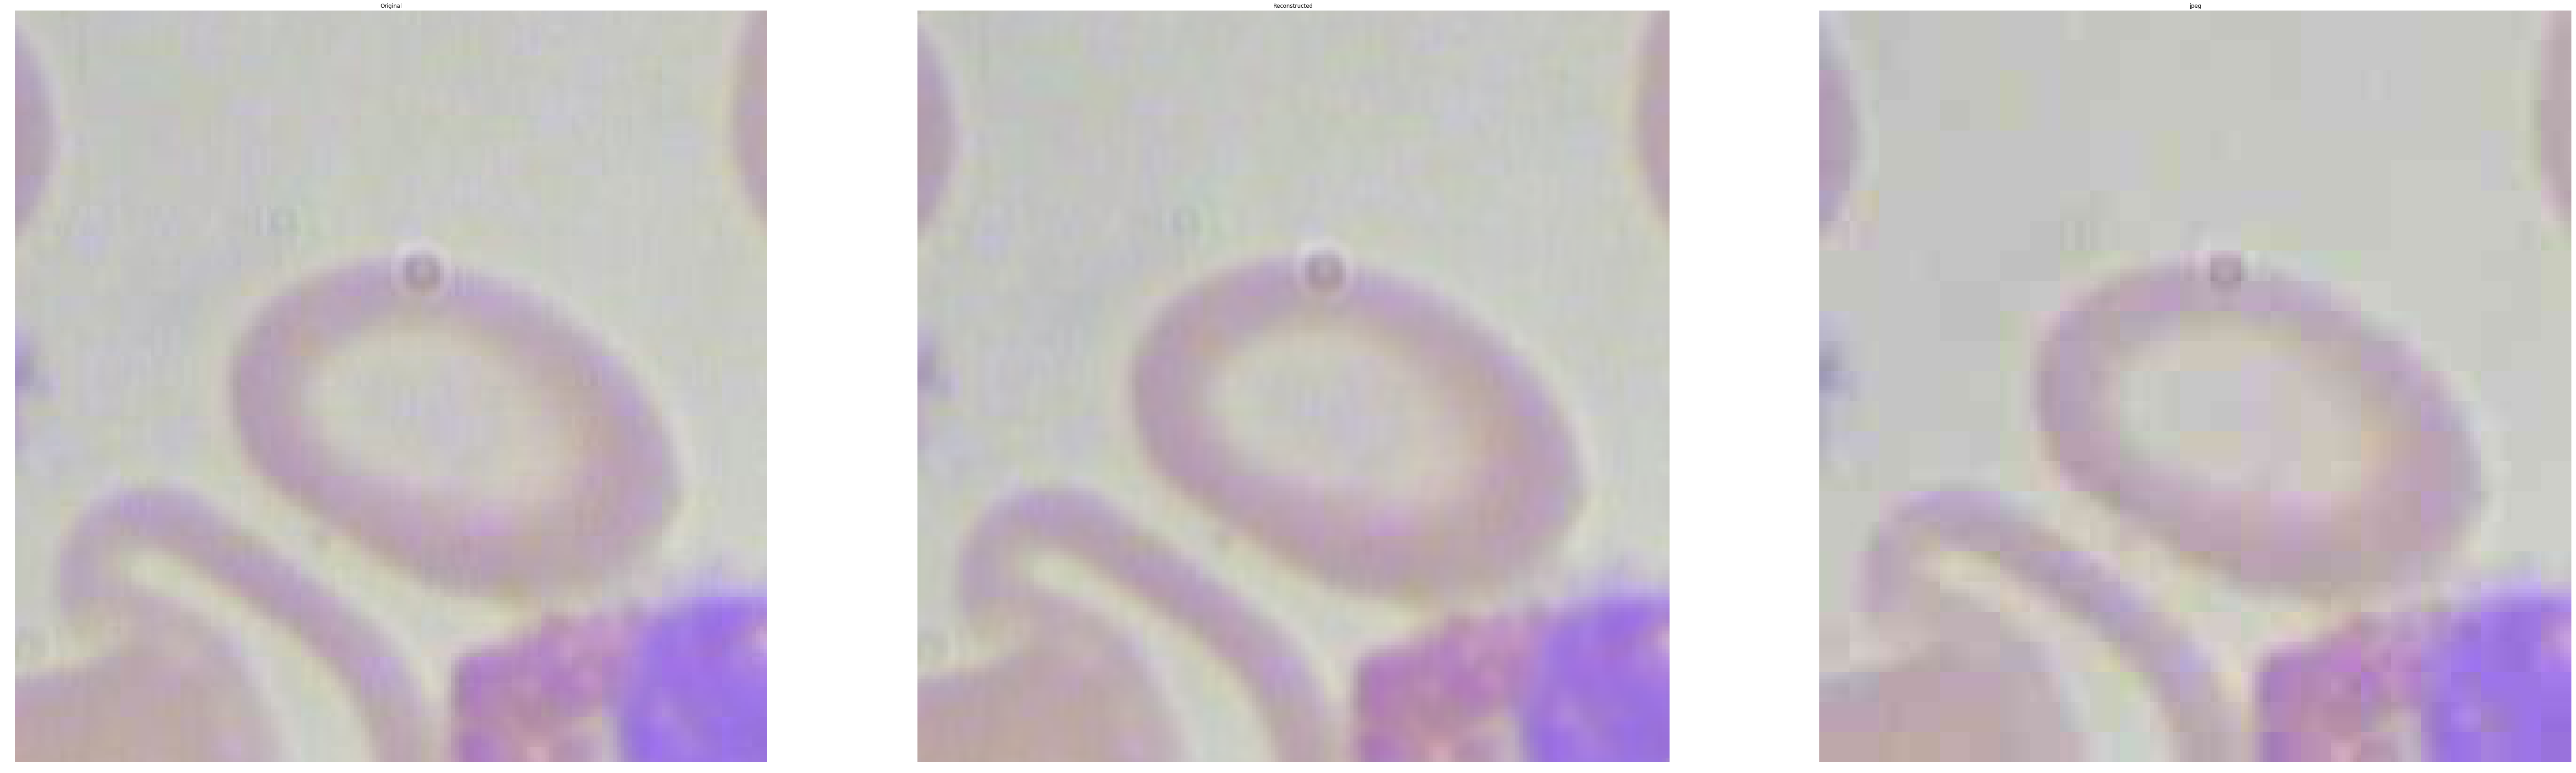

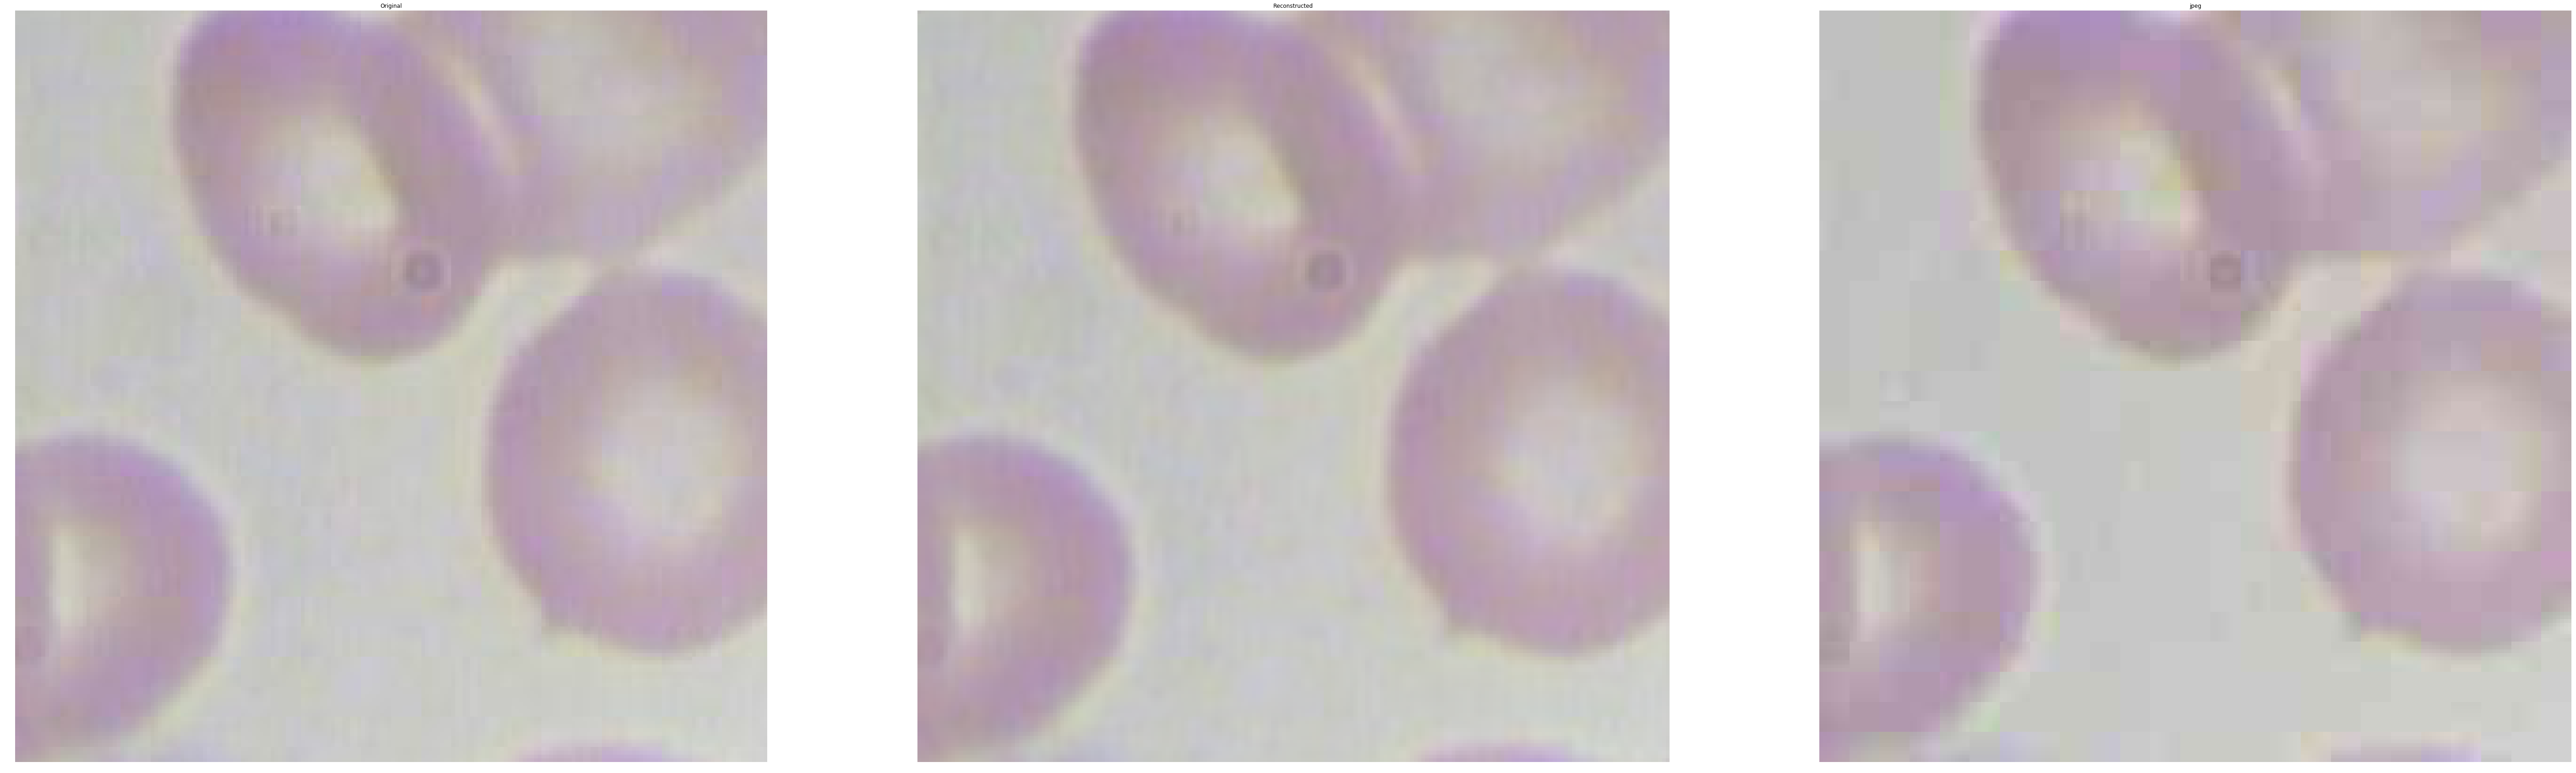

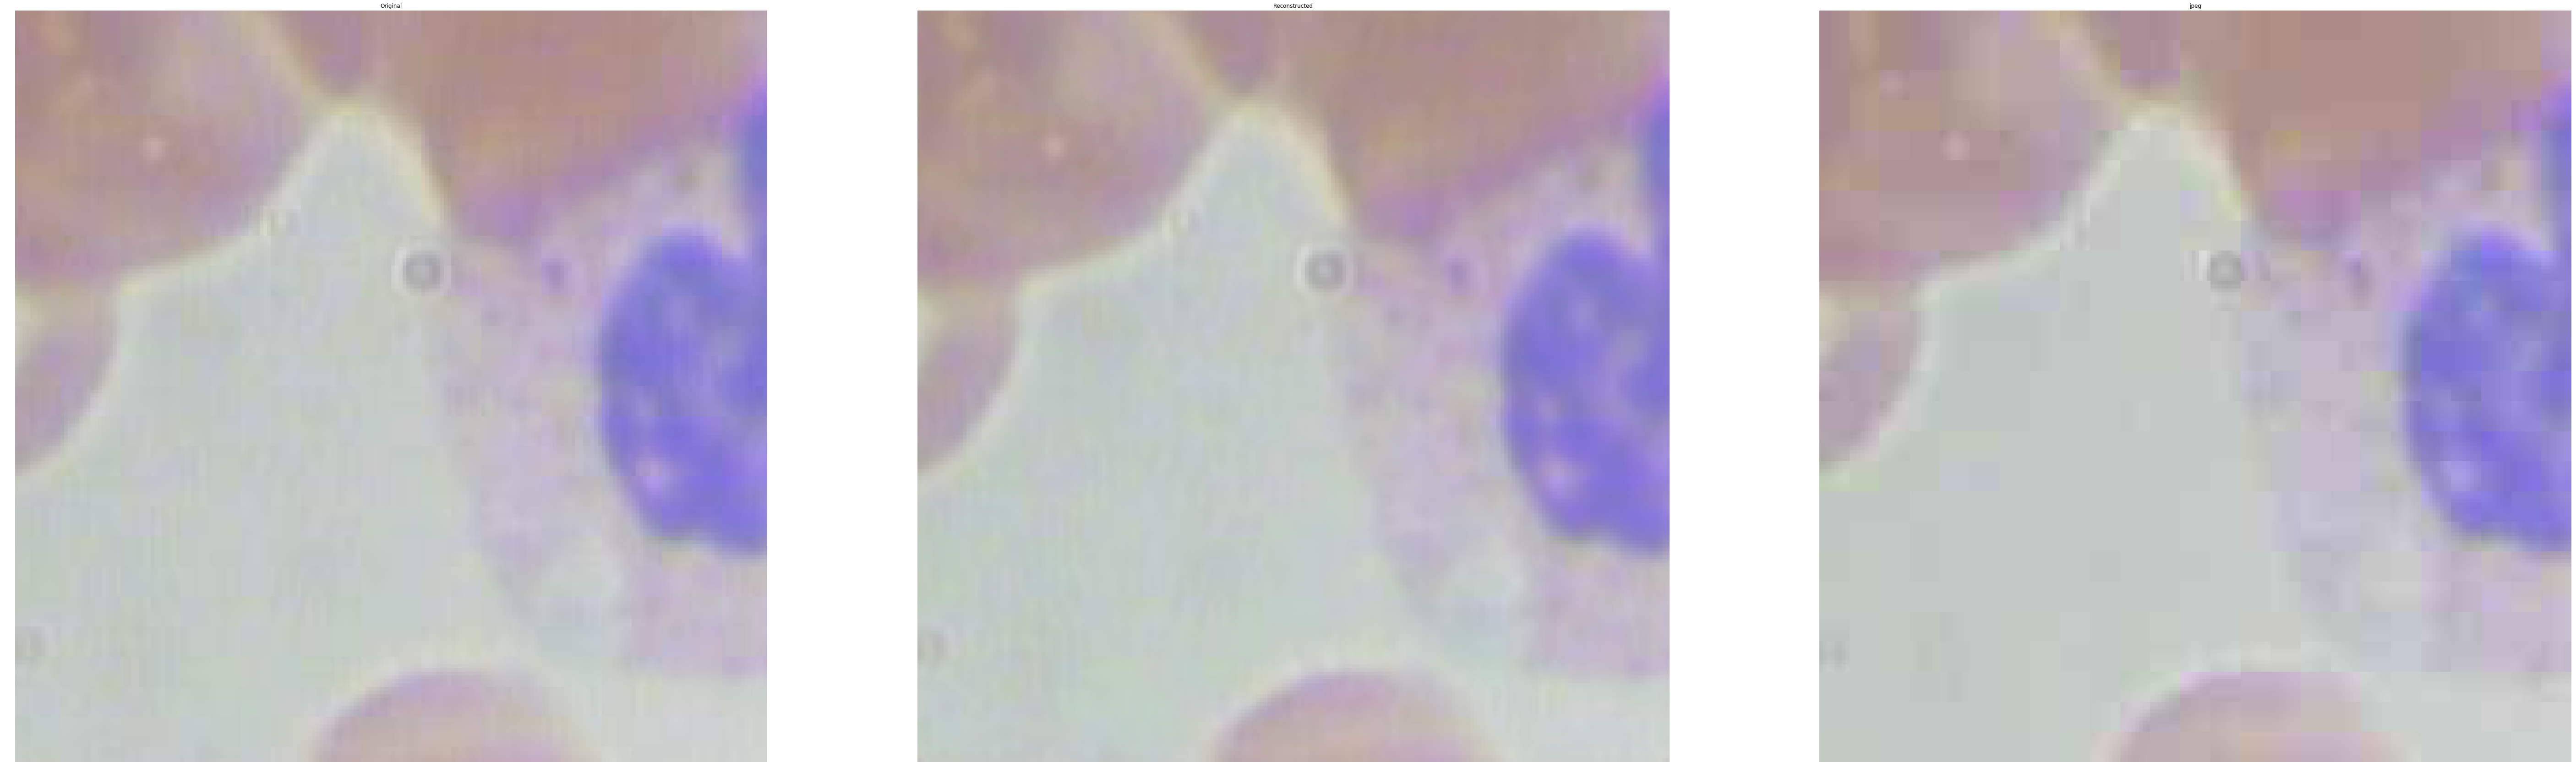

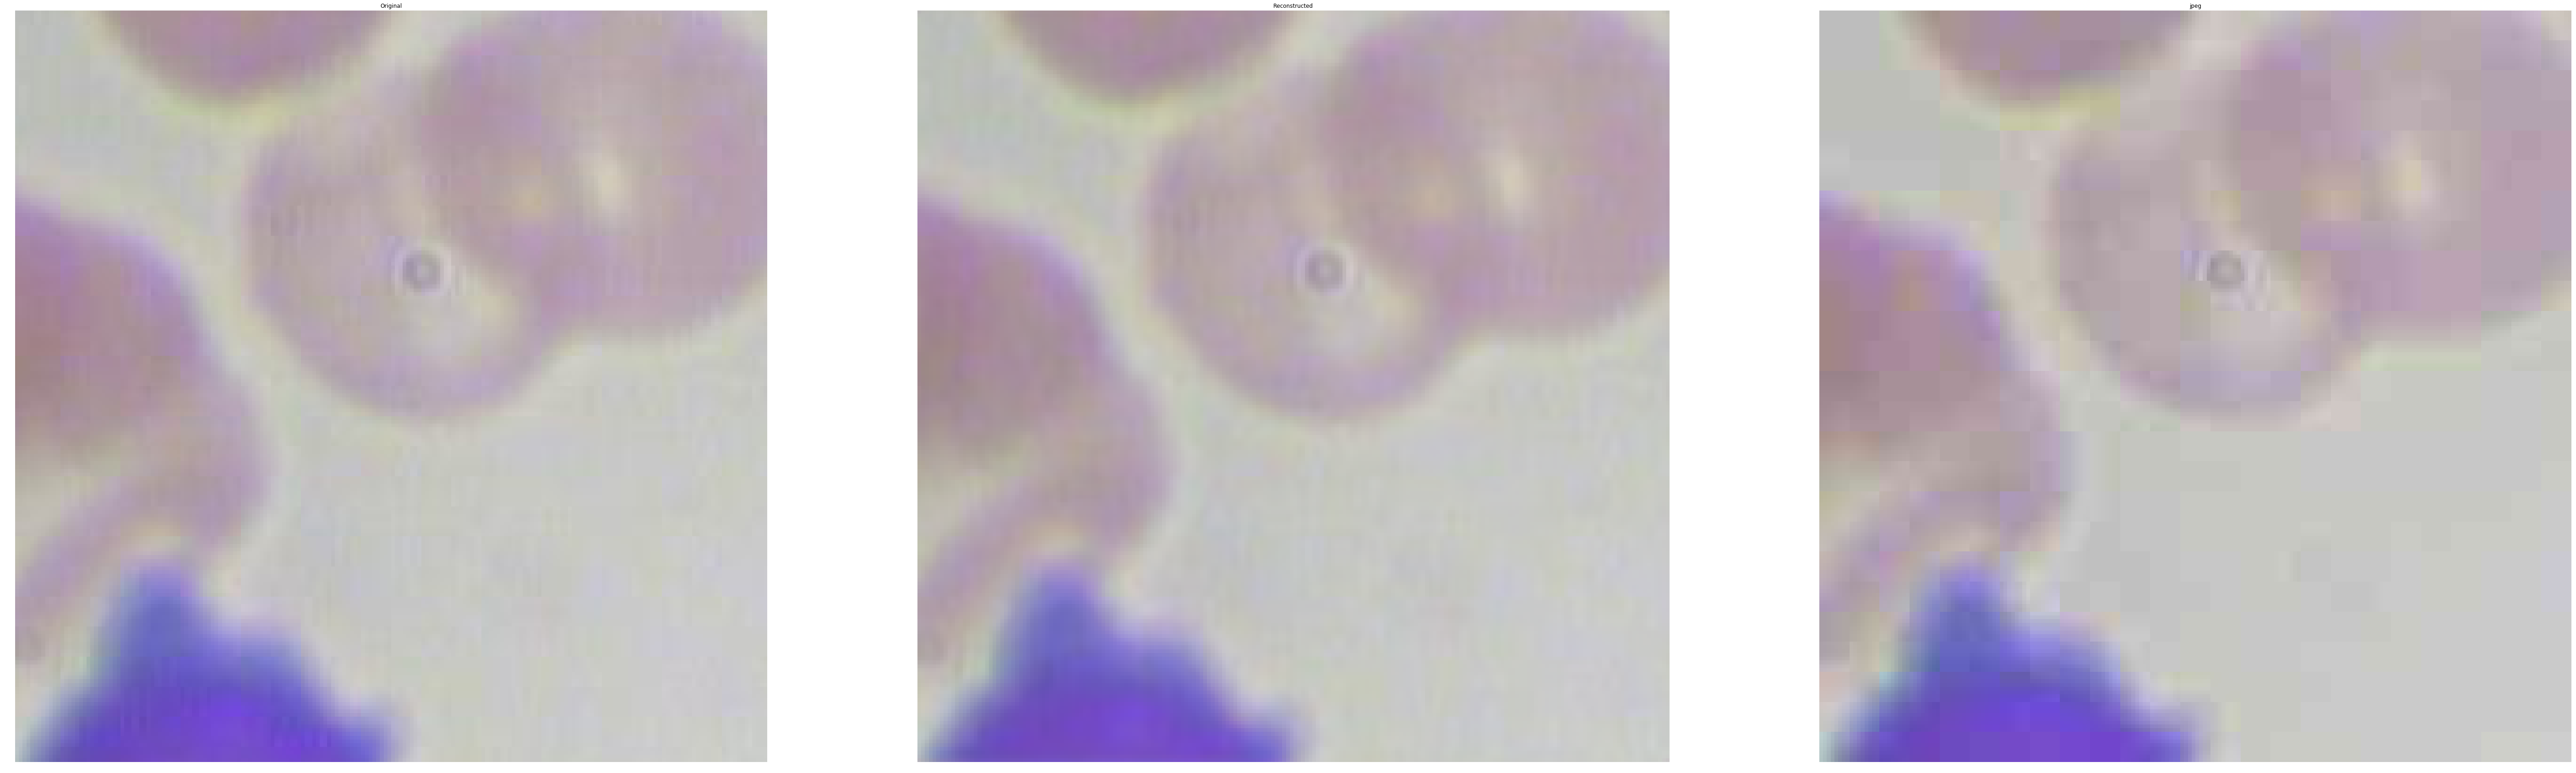

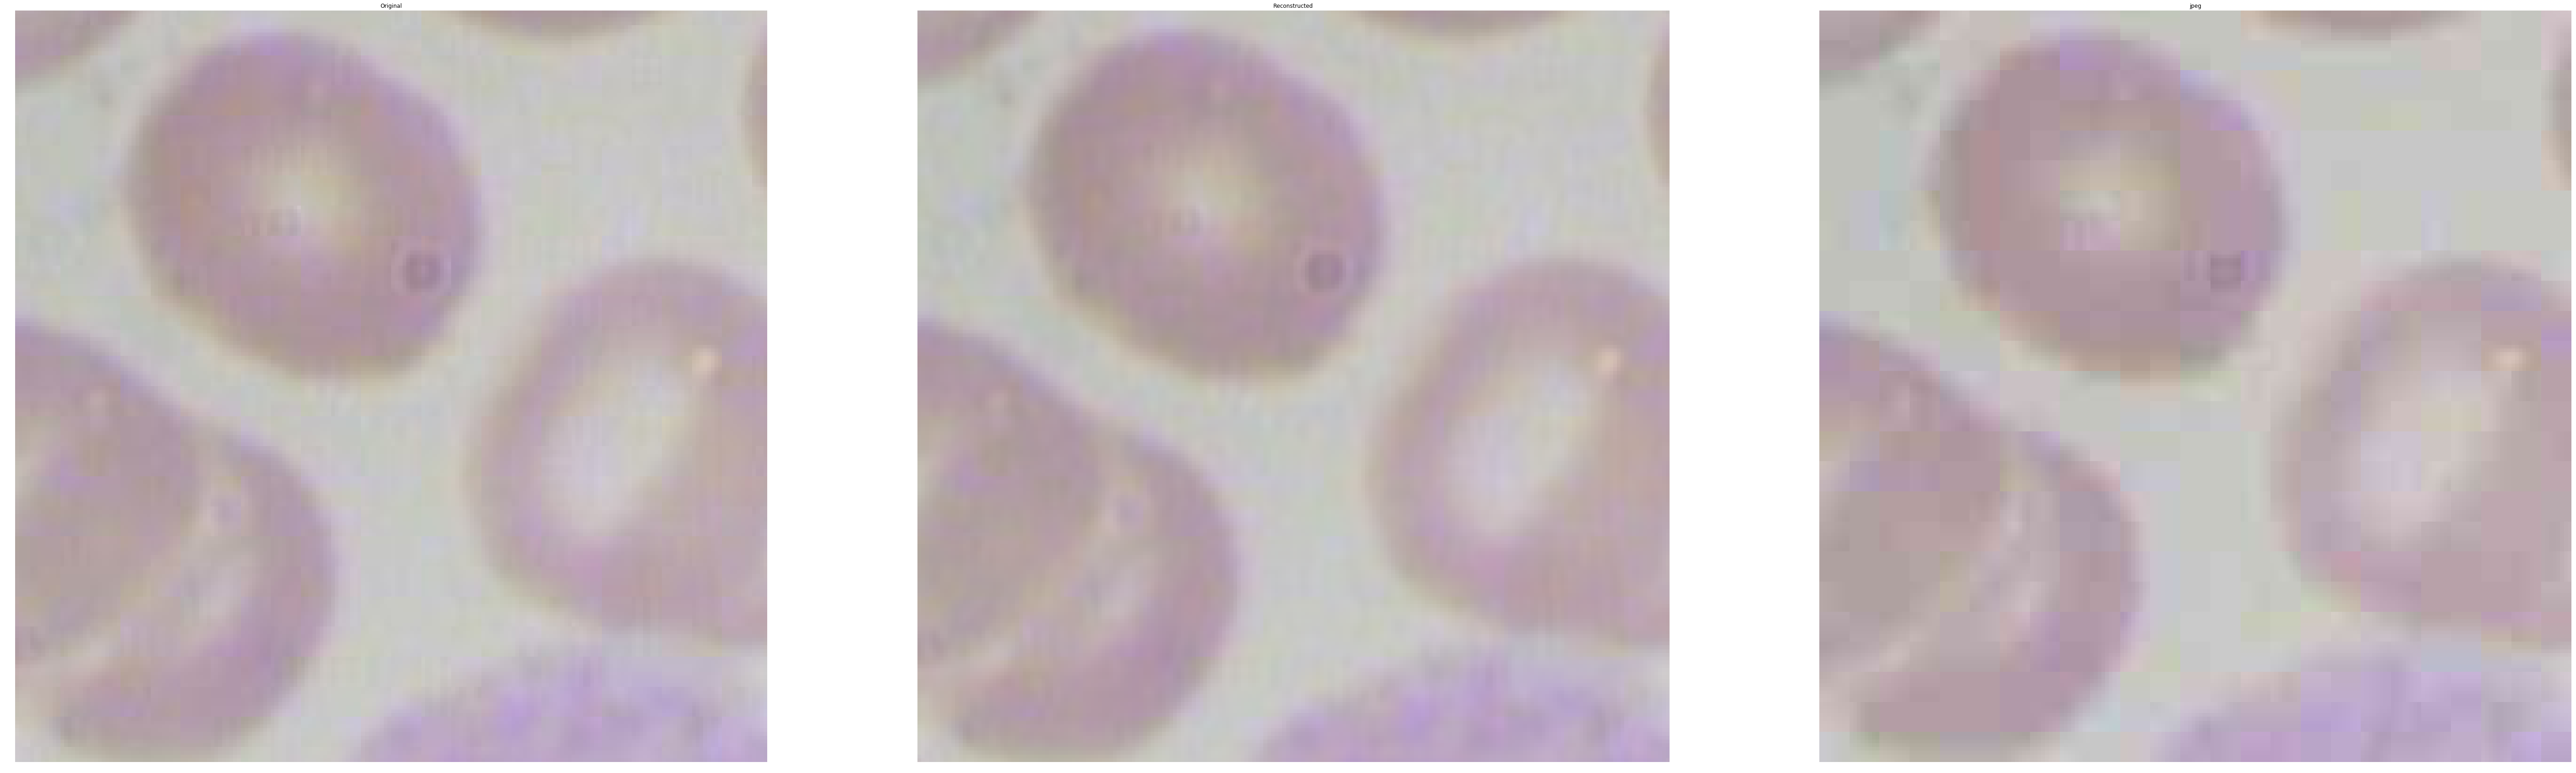

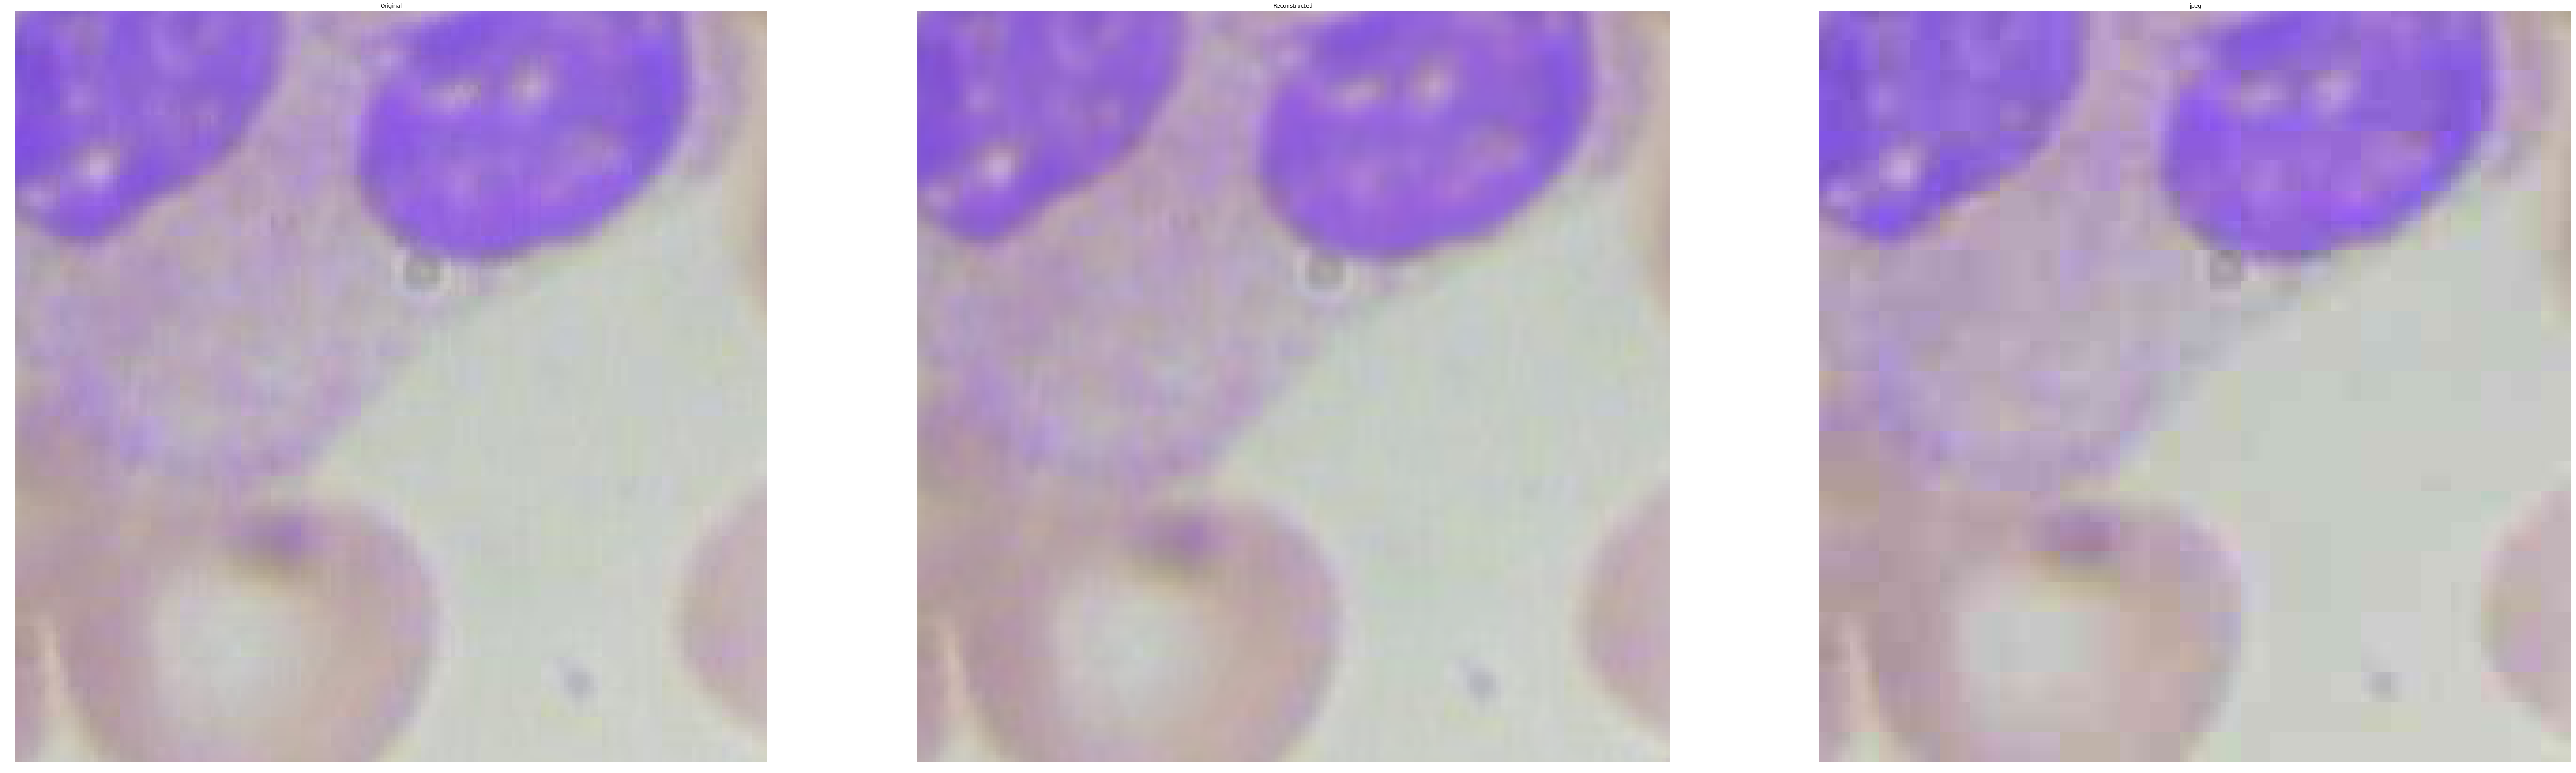

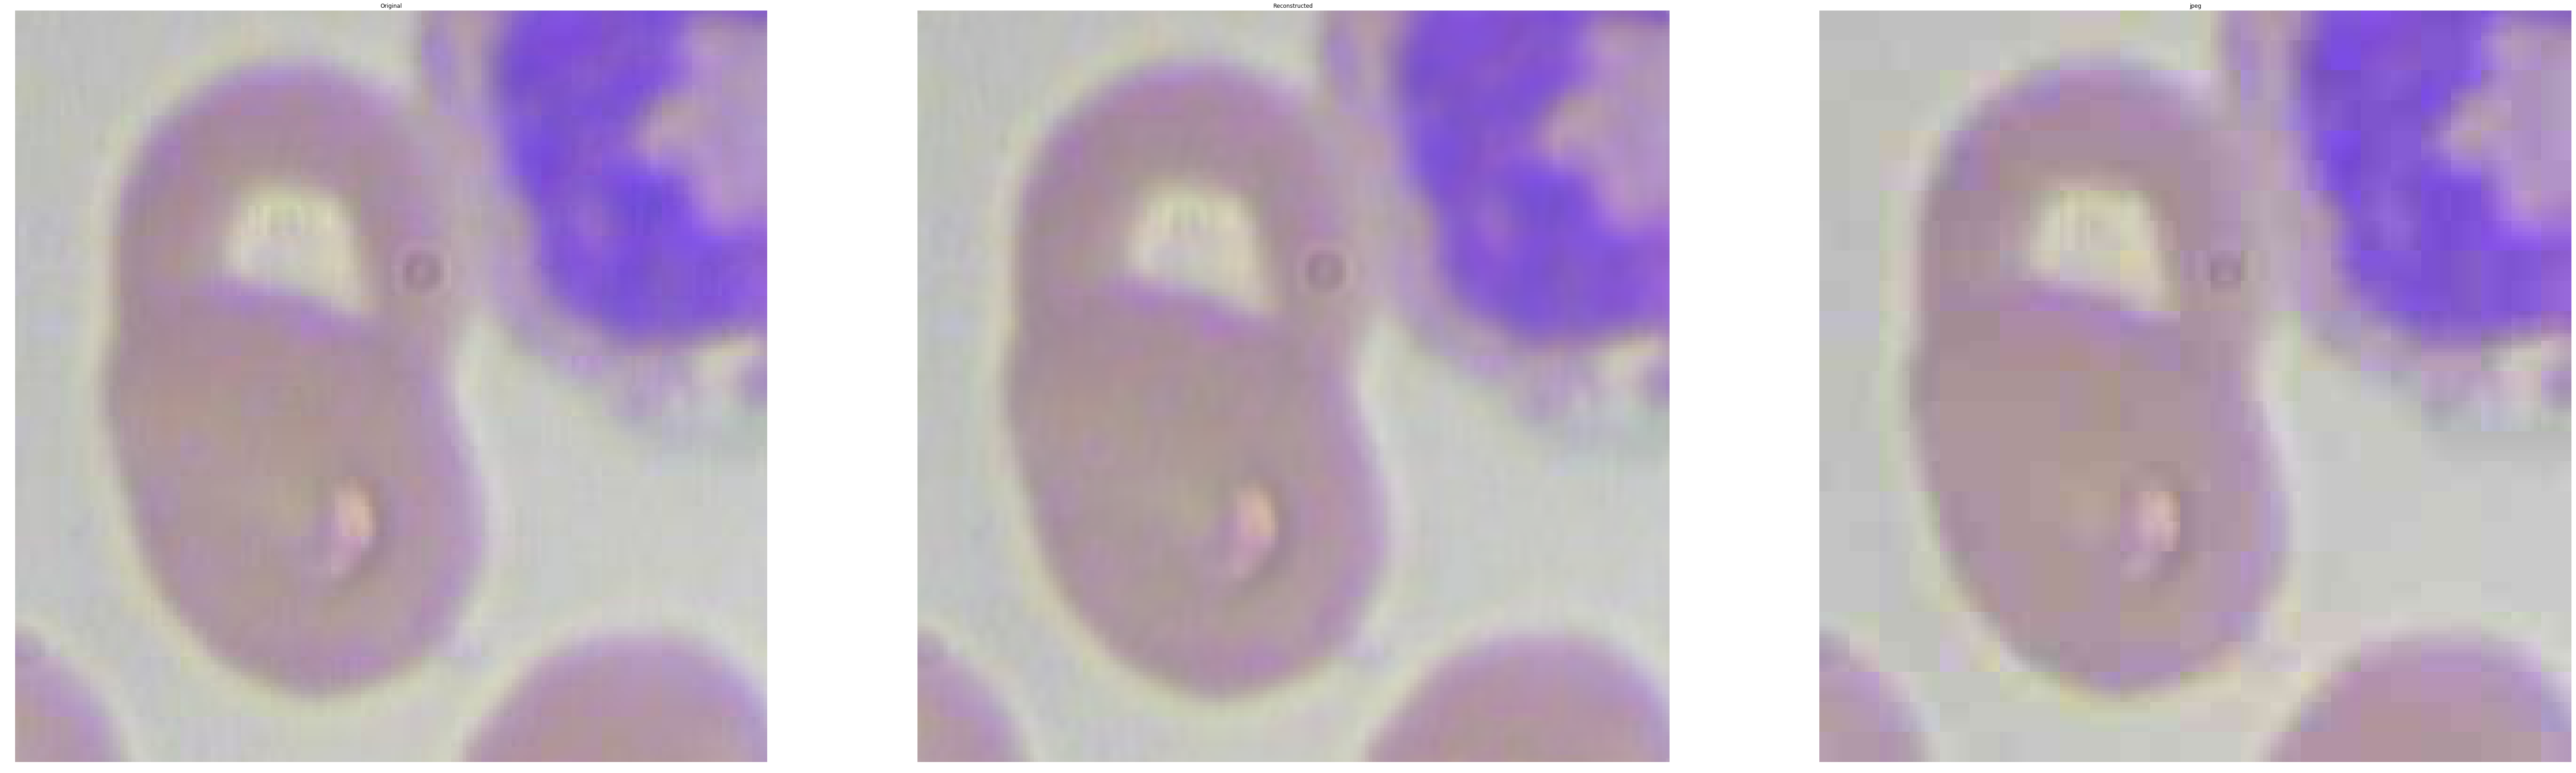

In [75]:
jpg_images = [[],[],[]]

def check_sizes(img):
    for i in range(1,100):
        jpeg_filename = "jpeg_visualizations/" + str(i) + "_jaypeg.jpeg"
        img.save(jpeg_filename,"JPEG",quality=i)
        statinfo = os.stat(jpeg_filename)
        print(statinfo.st_size,i)
        jpeg_compressed = Image.open(jpeg_filename)
        jpeg_compressed = np.asarray(jpeg_compressed)
        
##100,50,16,jpg 
        
        

def save_original_and_jpeg(data):
    img = data.cpu().detach()

    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        jpg_images[0].append(individual_img)

        rescaled = (255.0 * individual_img)
        rescaled = rescaled.astype('uint8')
        
        PIL_img = Image.fromarray(rescaled)
        check_sizes(PIL_img)
        
        jpeg_filename = "jpeg_visualizations/" + str(i) + "_jaypeg.jpeg"
        PIL_img.save(jpeg_filename,"JPEG",quality=30)
     
        jpeg_compressed = Image.open(jpeg_filename)
        jpeg_compressed = np.asarray(jpeg_compressed)
        jpg_images[2].append(jpeg_compressed)
        
def save_reconstruction(reconstruction):
    for i in range(reconstruction.shape[0]):
        recon = reconstruction[i].cpu().detach()
        recon = recon.numpy()
        recon = np.transpose(recon,(1,2,0))
        recon = np.clip(recon,0,1)
        jpg_images[1].append(recon)
        
i = 0
for data in cross_dataset_loader:
        with torch.no_grad():
            if i > 0: break
            data = data.to(device)
            save_original_and_jpeg(data)
            reconstruction = model(data)
            save_reconstruction(reconstruction)
            i+=1
            
for i in range(10):
        plt.figure(figsize=(100,100))
        #plt.figure()
        org = jpg_images[0][i]
        plt.subplot(1, 3, 1)
        plt.axis('off')
        #imshow_noax(org, normalize=False)
        plt.imshow(org)
        plt.title('Original')
        plt.subplot(1, 3, 2)
        rec = jpg_images[1][i]
        plt.imshow(rec)
        #imshow_noax(rec, normalize=False)
        plt.title('Reconstructed')
        plt.axis('off')
        image_str = net_type + "_" + original_dataset + "_" +cross_dataset+"_"+str(i) + ".png"
        plt.subplot(1, 3, 3)
        plt.axis('off')
        plt.imshow(jpg_images[2][i])
        plt.title('jpeg')
        #plt.savefig("cross_visualizations/"+image_str)
        plt.show()

Not working until all models are trained

In [ ]:
cross_datasets = ['xray','museum','blood_cell']#'museum' #'xray' #'blood_cell'
net_types = ['new','old'] #'old'
original_datasets = ['xray','museum','blood_cell'] #'museum' #'xray' 

for net_type in net_types:
    for original_dataset in original_datasets:
        for cross_dataset in cross_datasets:
            visualize(net_type,original_dataset,cross_dataset,device)
    


Visualize the Reconstructed Images